# Татьяна Чернова - ДЗ 2, задача 2. Inpainting

Задача вставки одного изображения в другое по контурам (маске) первого изображения может решаться различными способами. В своей работе для выделения маски объекта я использую модель смешанной семантико-паноптической сегментации MaskFormer, представленную в работе Нильса Рогге https://github.com/NielsRogge/Transformers-Tutorials/blob/master/MaskFormer/Inference/Inference_with_MaskFormer_for_semantic_%2B_panoptic_segmentation.ipynb  Идея основана на архитектуре DETR: декодер трансформера выдает бинарные маски с метками. MaskFormer входит в состав HF Transformers

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.5 MB/s eta 0:00:00


## Семантическая сегментация

Загружаем модель MaskFormer, настроенную на датасете семантической сегментации ADE20k, на основе трансформера [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin).

In [ ]:
from torch.utils.checkpoint import checkpoint

In [ ]:
from transformers import AutoImageProcessor, MaskFormerForInstanceSegmentation
from torch.utils.checkpoint import checkpoint

processor = AutoImageProcessor.from_pretrained("facebook/maskformer-swin-base-ade")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:408: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:415: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(


Загружаем изображение для обработки из датасета интерьеров, созданного для первой задачи.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


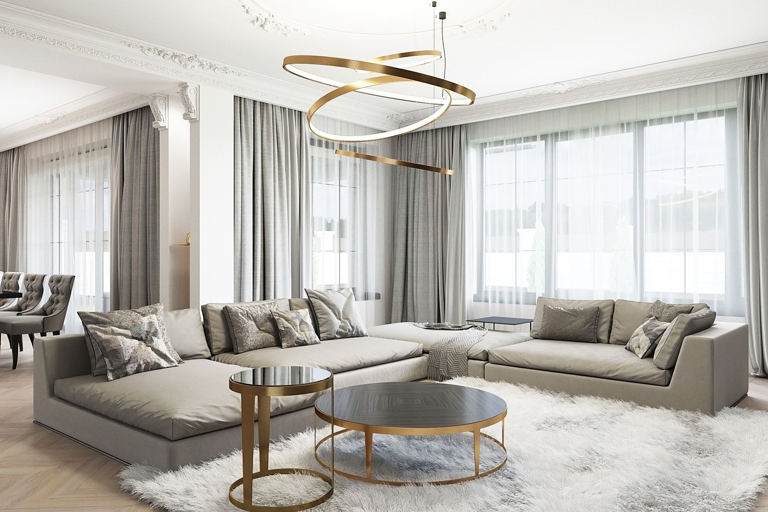

In [ ]:
from PIL import Image
image_path = "/content/drive/MyDrive/Colab Notebooks/СММО SF/HW2_Images/1_интерьер.jpg"
image = Image.open(image_path).convert("RGB").resize((768, 512))
image

обработка изображения для подачи в модель

In [ ]:
import torch

inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)

Постобработка для получения предсказанной карты семантической сегментации.

In [ ]:
# you can pass the `outputs` to processor for postprocessing
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_semantic_map

tensor([[5, 5, 5,  ..., 5, 5, 5],
        [5, 5, 5,  ..., 5, 5, 5],
        [5, 5, 5,  ..., 5, 5, 5],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]])

Определяем палитру цветов, присваивая классы каждому цвету (RGB).

In [ ]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

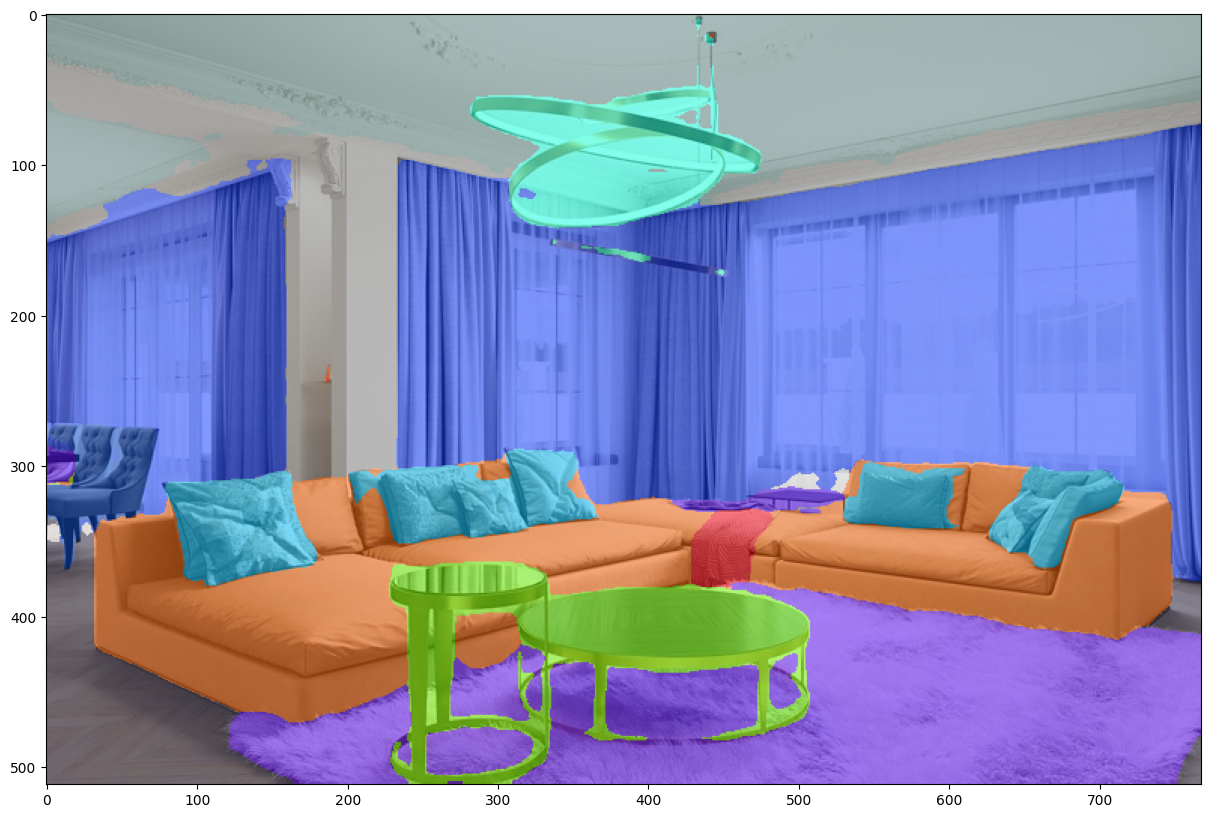

In [ ]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

seg = predicted_semantic_map

color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

## Паноптическая сегментация

In [ ]:
# pass the inputs to processor for postprocessing
results = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

`label_ids_to_fuse` unset. No instance will be fused.


Предсказания включают предсказанную карту паноптической сегментации и информацию о сегментах.

In [ ]:
results.keys()

dict_keys(['segmentation', 'segments_info'])

In [ ]:
results['segmentation']

tensor([[12, 12, 12,  ..., 12, 12, 12],
        [12, 12, 12,  ..., 12, 12, 12],
        [12, 12, 12,  ..., 12, 12, 12],
        ...,
        [11, 11, 11,  ..., 11, 11, 11],
        [11, 11, 11,  ..., 11, 11, 11],
        [11, 11, 11,  ..., 11, 11, 11]], dtype=torch.int32)

Предсказанные сегменты:

In [ ]:
for segment in results['segments_info']:
  print(segment)

{'id': 1, 'label_id': 36, 'was_fused': False, 'score': 0.98522}
{'id': 2, 'label_id': 131, 'was_fused': False, 'score': 0.868429}
{'id': 3, 'label_id': 28, 'was_fused': False, 'score': 0.99895}
{'id': 4, 'label_id': 19, 'was_fused': False, 'score': 0.997266}
{'id': 5, 'label_id': 64, 'was_fused': False, 'score': 0.995481}
{'id': 6, 'label_id': 15, 'was_fused': False, 'score': 0.984044}
{'id': 7, 'label_id': 0, 'was_fused': False, 'score': 0.996894}
{'id': 8, 'label_id': 39, 'was_fused': False, 'score': 0.999372}
{'id': 9, 'label_id': 23, 'was_fused': False, 'score': 0.999639}
{'id': 10, 'label_id': 18, 'was_fused': False, 'score': 0.996582}
{'id': 11, 'label_id': 3, 'was_fused': False, 'score': 0.998156}
{'id': 12, 'label_id': 5, 'was_fused': False, 'score': 0.999427}


In [ ]:
for segment in results['segments_info']:
  print(segment['id'], sep=' ', end=' ')
  print(segment['label_id'], sep=' ', end=' ')
  print(model.config.id2label[segment['label_id']])

1 36 lamp
2 131 blanket, cover
3 28 rug
4 19 chair
5 64 coffee table
6 15 table
7 0 wall
8 39 cushion
9 23 sofa
10 18 curtain
11 3 floor
12 5 ceiling


Отобразим маску люстры:

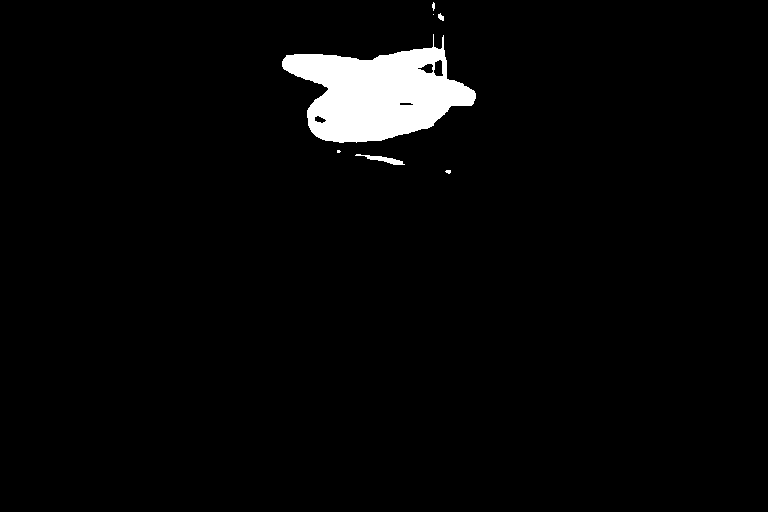

In [ ]:
import numpy as np

mask = (results['segmentation'].numpy() == 1)
visual_mask = (mask * 255).astype(np.uint8)
visual_mask = Image.fromarray(visual_mask)
visual_mask

Выберем люстру для замены изображения (inpainting)

In [ ]:
!pip install -qq -U diffusers==0.11.1 transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 7.7 MB/s eta 0:00:00


In [ ]:
import inspect
from typing import List, Optional, Union

#import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

In [ ]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

text_encoder/pytorch_model.fp16.safetensors not found


Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
from torchvision import transforms

preprocess_1 = transforms.Compose(
    [
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

preprocess_2 = transforms.Compose(
    [
        transforms.Resize((512, 512)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0], [1]),
    ]
)

In [ ]:
image_torch = preprocess_1(image.convert("RGB"))
mask_torch = preprocess_2(visual_mask)

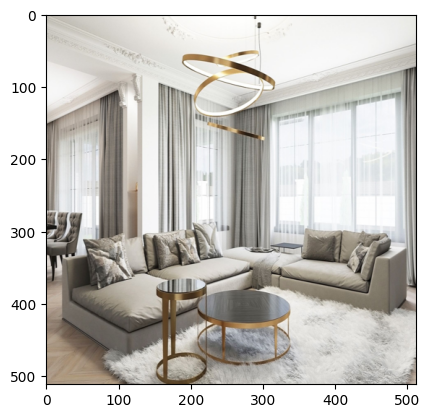

In [ ]:
plt.imshow(image_torch.permute(1, 2, 0).numpy() / 2 + 0.5)

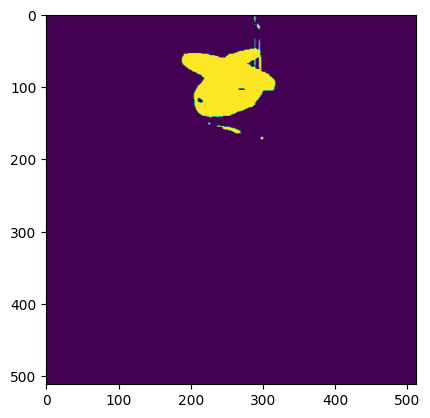

In [ ]:
plt.imshow(mask_torch.permute(1, 2, 0).numpy() / 2 + 0.5)

In [ ]:
prompt = "robot lamp"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image_torch,
    mask_image=mask_torch,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

image_grid(images, 1, num_samples + 1)

Выходные данные этой ячейки слишком велики. Войдите, чтобы просмотреть их.


In [ ]:
prompt1 = "a robot sitting on a coffee table"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images1 = pipe(
    prompt=prompt,
    image=image_torch,
    mask_image=mask_torch,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
images1.insert(0, image)

In [ ]:
image_grid(images1, 1, num_samples + 1)

Выходные данные этой ячейки слишком велики. Войдите, чтобы просмотреть их.


# Вывод: несмотря на то, что модель правильно понимает маску, она не заменяет ее желаемым объектом

### Gradio Demo

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 10.3 

In [ ]:
!pip install kaleido

In [ ]:
!pip install typing-extensions==4.6.0

In [ ]:
def predict(dict, prompt):
  image =  dict['image'].convert("RGB").resize((512, 512))
  mask_image = dict['mask'].convert("RGB").resize((512, 512))
  images = pipe(prompt=prompt, image=image, mask_image=visual_mask).images
  return(images[0])

In [ ]:
import gradio as gr
gr.Interface(
    predict,
    title = 'Stable Diffusion In-Painting',
    inputs=[
        gr.Image(source = 'upload', tool = 'sketch', type = 'pil'),
        gr.Textbox(label = 'prompt')
    ],
    outputs = [
        gr.Image()
        ]
).launch(debug=True)